In [287]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Paths
RAW_DATA_PATH = Path("../data/raw")
PROCESSED_DATA_PATH = Path("../data/processed")
PROCESSED_DATA_PATH.mkdir(exist_ok=True, parents=True)

print("✅ Setup complete")

✅ Setup complete


In [288]:
# Load Sample Data
week = "18"

input_df = pd.read_csv(RAW_DATA_PATH / f"input_2023_w{week}.csv")
output_df = pd.read_csv(RAW_DATA_PATH / f"output_2023_w{week}.csv")
supp_df = pd.read_csv(RAW_DATA_PATH / "supplementary_data.csv")

# Merge
df = input_df.merge(supp_df, on=['game_id', 'play_id'], how='left')

print(f"Loaded {len(df):,} rows, {df['game_id'].nunique()} games, "
      f"{df[['game_id', 'play_id']].drop_duplicates().shape[0]} plays")

Loaded 254,917 rows, 16 games, 750 plays


In [289]:
# Define Prediction Problem
print("=" * 80)
print("PREDICTION PROBLEM DEFINITION")
print("=" * 80)
print("""
TARGET:
  - Predict future (x, y) positions for each player over `num_frames_output` frames
  - Granularity: Per player, per frame after the pass is thrown
  
INPUT FEATURES:
  - Pre-throw tracking data (position, velocity, acceleration, orientation)
  - Player attributes (position, role, height, weight)
  - Play context (coverage, formation, down/distance, field position)
  - Relative features (distances, angles to key players/locations)
  
APPROACH:
  1. Engineer features at the frame level (kinematics, relative positions)
  2. Aggregate play-level context features
  3. Create sequence features for temporal models (LSTM, Transformer)
""")

PREDICTION PROBLEM DEFINITION

TARGET:
  - Predict future (x, y) positions for each player over `num_frames_output` frames
  - Granularity: Per player, per frame after the pass is thrown

INPUT FEATURES:
  - Pre-throw tracking data (position, velocity, acceleration, orientation)
  - Player attributes (position, role, height, weight)
  - Play context (coverage, formation, down/distance, field position)
  - Relative features (distances, angles to key players/locations)

APPROACH:
  1. Engineer features at the frame level (kinematics, relative positions)
  2. Aggregate play-level context features
  3. Create sequence features for temporal models (LSTM, Transformer)



In [290]:
# Feature Engineering - Kinematics
def add_kinematic_features(df):
    """Add smoothed speed, acceleration, jerk, and turn rate"""
    
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).copy()
    
    # Smoothed speed and acceleration (rolling mean over 3 frames)
    df['s_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df['a_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    
    # Jerk (rate of change of acceleration)
    df['jerk'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].diff()
    
    # Turn rate (change in direction)
    df['dir_change'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['dir'].diff()
    # Handle wraparound (e.g., 359° to 1° should be 2°, not -358°)
    df['dir_change'] = df['dir_change'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    
    # Bearing difference (difference between orientation and direction)
    df['bearing_diff'] = df['o'] - df['dir']
    df['bearing_diff'] = df['bearing_diff'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    
    return df

# Apply
df = add_kinematic_features(df)

print("✅ Kinematic features added:")
print("  - s_smooth, a_smooth (rolling mean)")
print("  - jerk (rate of change of acceleration)")
print("  - dir_change (turn rate)")
print("  - bearing_diff (orientation vs direction)")

✅ Kinematic features added:
  - s_smooth, a_smooth (rolling mean)
  - jerk (rate of change of acceleration)
  - dir_change (turn rate)
  - bearing_diff (orientation vs direction)


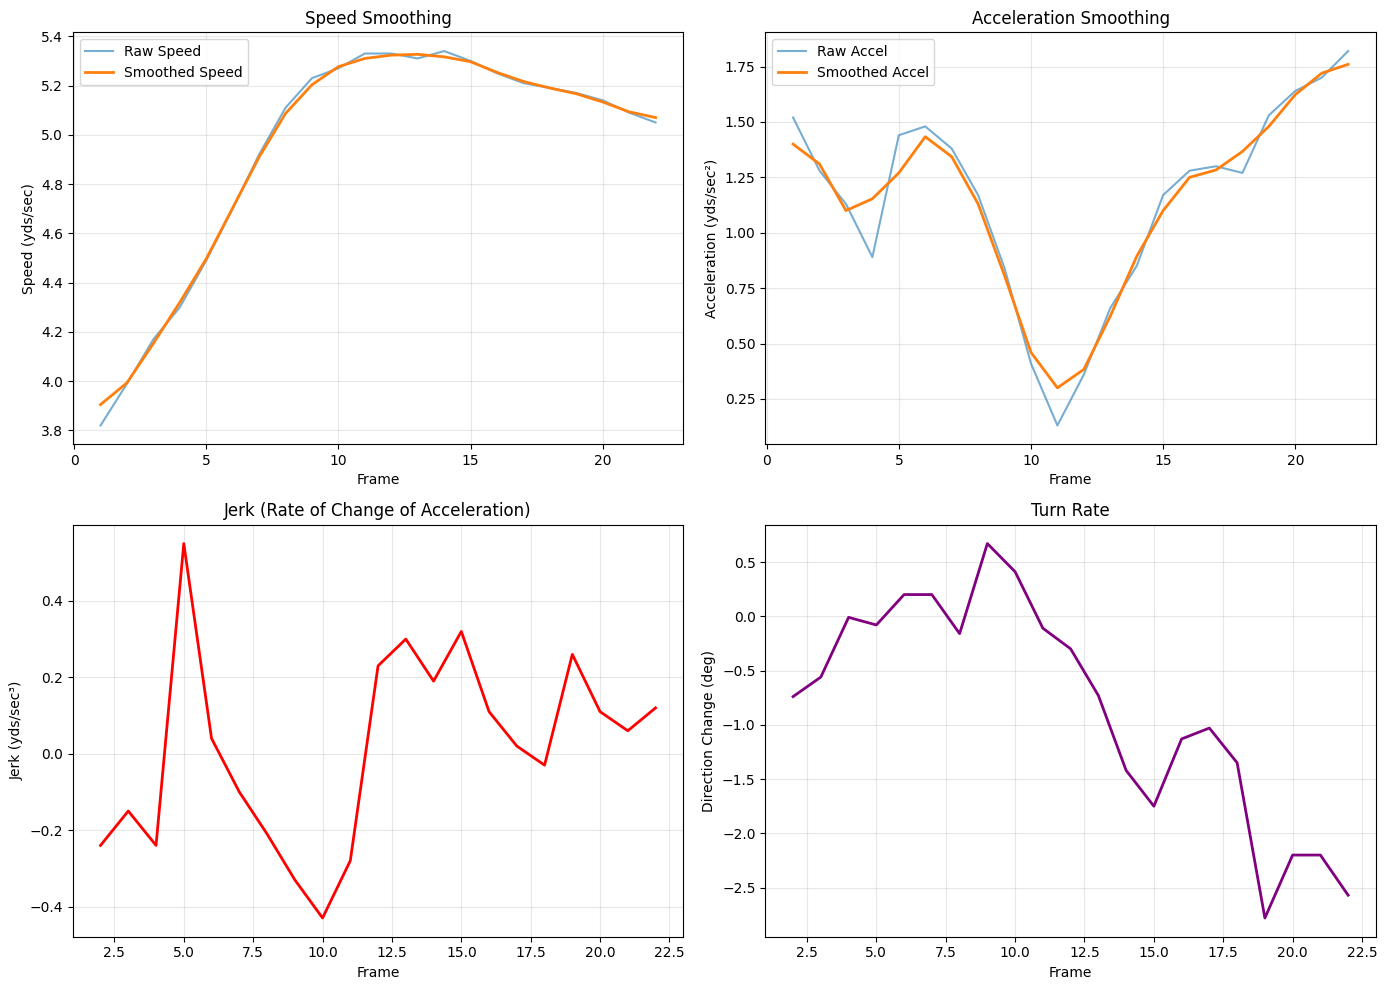

In [291]:
# Visualize Kinematic Features
sample_player = df[df['player_to_predict'] == True].iloc[0]
sample_data = df[
    (df['game_id'] == sample_player['game_id']) &
    (df['play_id'] == sample_player['play_id']) &
    (df['nfl_id'] == sample_player['nfl_id'])
].sort_values('frame_id')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Speed
axes[0, 0].plot(sample_data['frame_id'], sample_data['s'], label='Raw Speed', alpha=0.6)
axes[0, 0].plot(sample_data['frame_id'], sample_data['s_smooth'], label='Smoothed Speed', linewidth=2)
axes[0, 0].set_xlabel('Frame')
axes[0, 0].set_ylabel('Speed (yds/sec)')
axes[0, 0].set_title('Speed Smoothing')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Acceleration
axes[0, 1].plot(sample_data['frame_id'], sample_data['a'], label='Raw Accel', alpha=0.6)
axes[0, 1].plot(sample_data['frame_id'], sample_data['a_smooth'], label='Smoothed Accel', linewidth=2)
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Acceleration (yds/sec²)')
axes[0, 1].set_title('Acceleration Smoothing')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Jerk
axes[1, 0].plot(sample_data['frame_id'], sample_data['jerk'], color='red', linewidth=2)
axes[1, 0].set_xlabel('Frame')
axes[1, 0].set_ylabel('Jerk (yds/sec³)')
axes[1, 0].set_title('Jerk (Rate of Change of Acceleration)')
axes[1, 0].grid(True, alpha=0.3)

# Direction change
axes[1, 1].plot(sample_data['frame_id'], sample_data['dir_change'], color='purple', linewidth=2)
axes[1, 1].set_xlabel('Frame')
axes[1, 1].set_ylabel('Direction Change (deg)')
axes[1, 1].set_title('Turn Rate')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(Path("../visualizations") / "09_kinematic_features.png", dpi=300, bbox_inches='tight')
plt.show()

In [292]:
# Feature Engineering - Relative Positions
def add_relative_position_features(df):
    """Add distances and angles to key locations and players"""
    
    df = df.copy()
    
    # Distance to ball landing spot
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 + 
        (df['y'] - df['ball_land_y'])**2
    )
    
    # Angle to ball landing spot
    df['angle_to_ball_land'] = np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    ) * 180 / np.pi
    
    # For each play, find QB, targeted receiver, and calculate distances
    def calc_player_distances(group):
        # Find QB (Passer)
        qb = group[group['player_role'] == 'Passer']
        if len(qb) > 0:
            qb_x, qb_y = qb['x'].iloc[0], qb['y'].iloc[0]
            group['dist_to_qb'] = np.sqrt((group['x'] - qb_x)**2 + (group['y'] - qb_y)**2)
        else:
            group['dist_to_qb'] = np.nan
        
        # Find targeted receiver
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            group['dist_to_target'] = np.sqrt((group['x'] - target_x)**2 + (group['y'] - target_y)**2)
        else:
            group['dist_to_target'] = np.nan
        
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_player_distances)
    
    # Distance to sidelines
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = df[['dist_to_left_sideline', 'dist_to_right_sideline']].min(axis=1)
    
    # Distance to end zones
    df['dist_to_own_endzone'] = df.apply(
        lambda row: row['x'] if row['play_direction'] == 'right' else 120 - row['x'],
        axis=1
    )
    df['dist_to_opp_endzone'] = 120 - df['dist_to_own_endzone']
    
    return df

# Apply
df = add_relative_position_features(df)

print("✅ Relative position features added:")
print("  - dist_to_ball_land, angle_to_ball_land")
print("  - dist_to_qb, dist_to_target")
print("  - dist_to_nearest_sideline")
print("  - dist_to_own_endzone, dist_to_opp_endzone")

✅ Relative position features added:
  - dist_to_ball_land, angle_to_ball_land
  - dist_to_qb, dist_to_target
  - dist_to_nearest_sideline
  - dist_to_own_endzone, dist_to_opp_endzone


In [293]:
# Feature Engineering - Coverage & Separation
def add_coverage_features(df):
    """Add separation metrics for coverage analysis"""
    
    df = df.copy()
    
    # For each frame, calculate nearest offensive and defensive player
    def calc_nearest_players(group):
        offense = group[group['player_side'] == 'Offense'][['x', 'y', 'nfl_id']].values
        defense = group[group['player_side'] == 'Defense'][['x', 'y', 'nfl_id']].values
        
        # For each player, find nearest opponent
        nearest_opp_dist = []
        for _, row in group.iterrows():
            if row['player_side'] == 'Offense':
                opponents = defense
            else:
                opponents = offense
            
            if len(opponents) > 0:
                distances = [euclidean([row['x'], row['y']], opp[:2]) for opp in opponents]
                nearest_opp_dist.append(min(distances))
            else:
                nearest_opp_dist.append(np.nan)
        
        group['nearest_opponent_dist'] = nearest_opp_dist
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_nearest_players)
    
    # Separation for targeted receiver (distance to nearest defender)
    def calc_receiver_separation(group):
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            defenders = group[group['player_side'] == 'Defense']
            if len(defenders) > 0:
                defender_dists = np.sqrt((defenders['x'] - target_x)**2 + (defenders['y'] - target_y)**2)
                min_separation = defender_dists.min()
                group['receiver_separation'] = min_separation
            else:
                group['receiver_separation'] = np.nan
        else:
            group['receiver_separation'] = np.nan
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_receiver_separation)
    
    # Player density (count within 5-yard radius)
    def calc_density(group):
        densities = []
        for _, row in group.iterrows():
            others = group[group['nfl_id'] != row['nfl_id']]
            distances = np.sqrt((others['x'] - row['x'])**2 + (others['y'] - row['y'])**2)
            density = (distances <= 5).sum()
            densities.append(density)
        group['player_density_5yd'] = densities
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_density)
    
    return df

# Apply (this may take a minute)
print("⏳ Calculating coverage features (this may take a minute)...")
df = add_coverage_features(df)

print("✅ Coverage features added:")
print("  - nearest_opponent_dist")
print("  - receiver_separation")
print("  - player_density_5yd")

⏳ Calculating coverage features (this may take a minute)...
✅ Coverage features added:
  - nearest_opponent_dist
  - receiver_separation
  - player_density_5yd


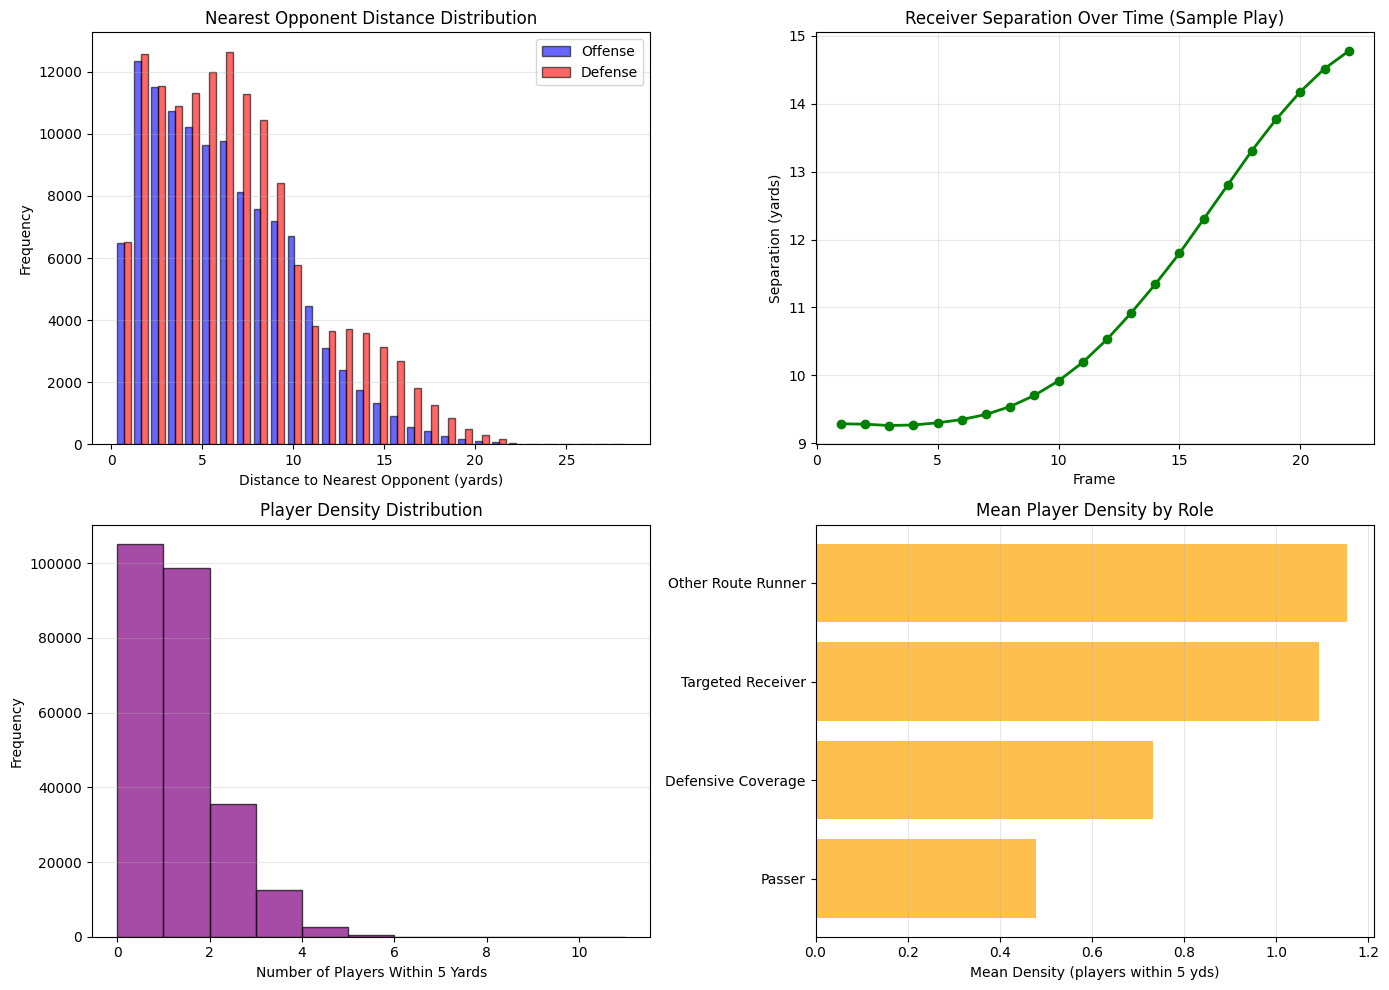

In [294]:
# Visualize Coverage Features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Nearest opponent distance by side
offense_dist = df[df['player_side'] == 'Offense']['nearest_opponent_dist'].dropna()
defense_dist = df[df['player_side'] == 'Defense']['nearest_opponent_dist'].dropna()
axes[0, 0].hist([offense_dist, defense_dist], bins=30, label=['Offense', 'Defense'], 
                color=['blue', 'red'], alpha=0.6, edgecolor='black')
axes[0, 0].set_xlabel('Distance to Nearest Opponent (yards)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Nearest Opponent Distance Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Receiver separation over time (sample play)
sample_play = df[df['receiver_separation'].notna()][['game_id', 'play_id']].drop_duplicates().iloc[0]
play_data = df[(df['game_id'] == sample_play['game_id']) & (df['play_id'] == sample_play['play_id'])]
play_data = play_data.groupby('frame_id')['receiver_separation'].first().reset_index()
axes[0, 1].plot(play_data['frame_id'], play_data['receiver_separation'], 
                color='green', linewidth=2, marker='o')
axes[0, 1].set_xlabel('Frame')
axes[0, 1].set_ylabel('Separation (yards)')
axes[0, 1].set_title('Receiver Separation Over Time (Sample Play)')
axes[0, 1].grid(True, alpha=0.3)

# Player density distribution
axes[1, 0].hist(df['player_density_5yd'], bins=range(0, 12), 
                color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Number of Players Within 5 Yards')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Player Density Distribution')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Density by player role
role_density = df.groupby('player_role')['player_density_5yd'].mean().sort_values()
axes[1, 1].barh(role_density.index, role_density.values, color='orange', alpha=0.7)
axes[1, 1].set_xlabel('Mean Density (players within 5 yds)')
axes[1, 1].set_title('Mean Player Density by Role')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(Path("../visualizations") / "11_coverage_features.png", dpi=300, bbox_inches='tight')
plt.show()

In [295]:
# Feature Engineering - Play Context
def add_play_context_features(df):
    """Add encoded play-level contextual features"""
    
    df = df.copy()
    
    # Encode categorical features
    categorical_cols = [
        'team_coverage_man_zone', 'team_coverage_type', 'dropback_type',
        'route_of_targeted_receiver', 'offense_formation', 'pass_result',
        'player_position', 'player_role', 'player_side'
    ]
    
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    # Situational features
    df['score_differential'] = df['pre_snap_home_score'] - df['pre_snap_visitor_score']
    
    # Field position (normalized to 0-1, where 1 is opponent's goal line)
    df['field_position_norm'] = df['absolute_yardline_number'] / 100
    
    # Down & distance features
    df['yards_to_go_norm'] = df['yards_to_go'] / 10  # Normalize by first down distance
    df['down_distance_ratio'] = df['yards_to_go'] / (df['down'] + 1)  # Avoid div by 0
    
    # Time features (convert game_clock MM:SS to seconds)
    if 'game_clock' in df.columns:
        df['game_clock_seconds'] = df['game_clock'].apply(
            lambda x: int(str(x).split(':')[0]) * 60 + int(str(x).split(':')[1]) if pd.notna(x) and ':' in str(x) else np.nan
        )
    
    # Play action indicator
    if 'play_action' in df.columns:
        df['play_action_binary'] = df['play_action'].map({'Y': 1, 'N': 0})
    
    return df, label_encoders

# Apply
df, label_encoders = add_play_context_features(df)

print("✅ Play context features added:")
print("  - Encoded categorical features (coverage, formation, route, etc.)")
print("  - score_differential")
print("  - field_position_norm")
print("  - yards_to_go_norm, down_distance_ratio")
print("  - game_clock_seconds")
print("  - play_action_binary")

✅ Play context features added:
  - Encoded categorical features (coverage, formation, route, etc.)
  - score_differential
  - field_position_norm
  - yards_to_go_norm, down_distance_ratio
  - game_clock_seconds
  - play_action_binary


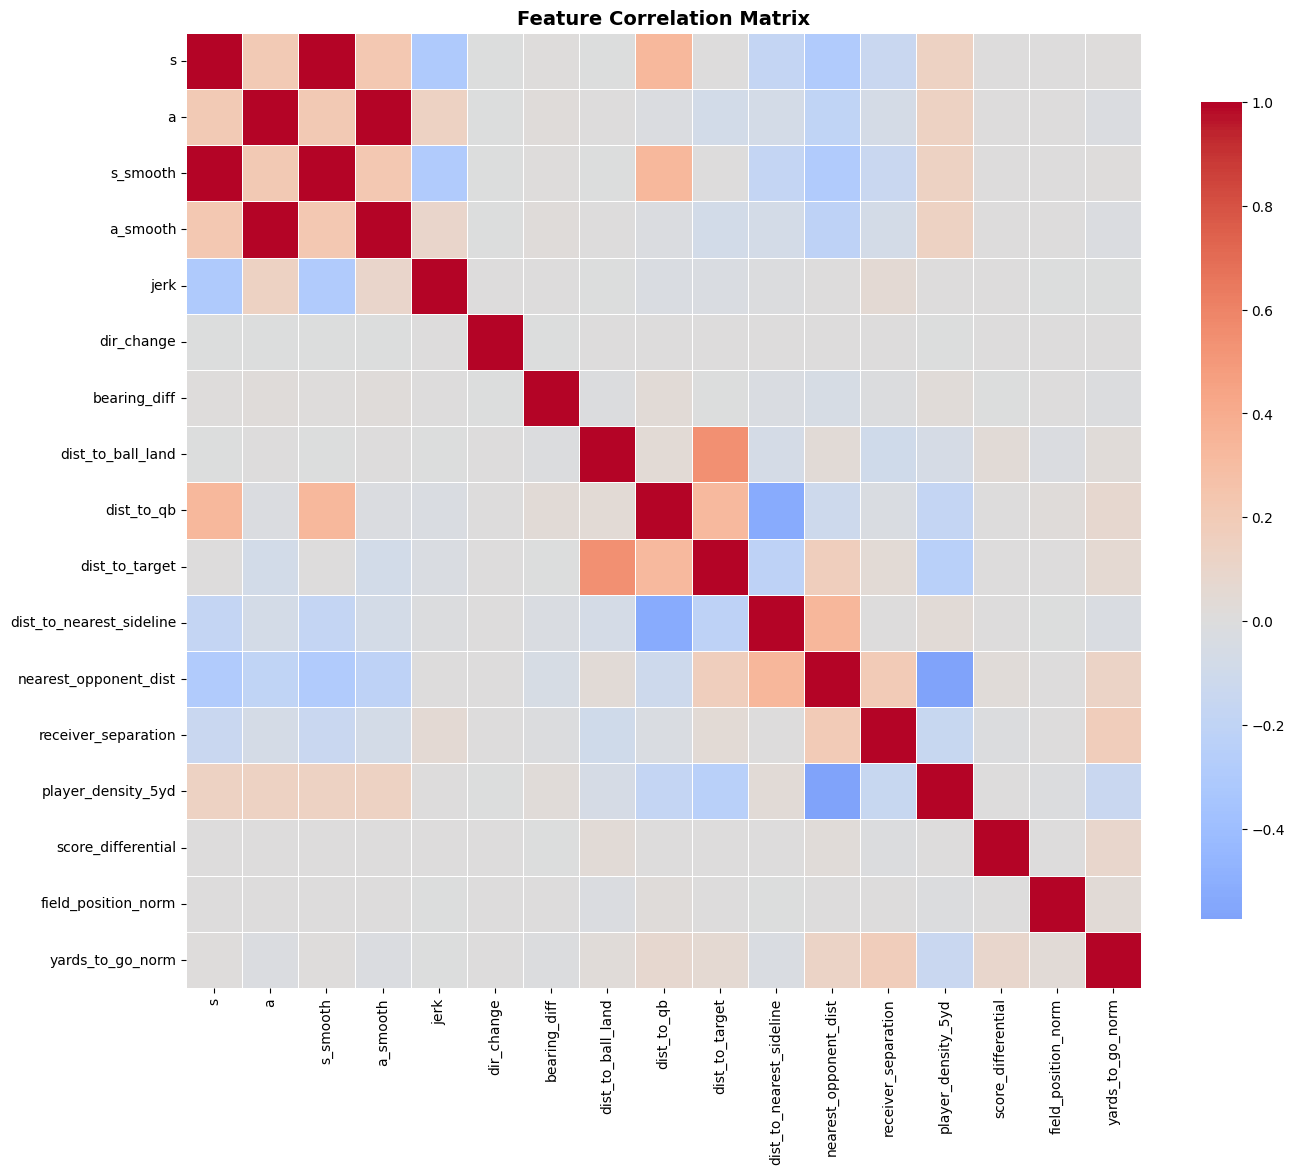


HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)
  s <-> s_smooth: 1.000
  a <-> a_smooth: 0.996


In [296]:
# Feature Correlation Analysis
# Select numeric features for correlation
numeric_features = [
    's', 'a', 's_smooth', 'a_smooth', 'jerk', 'dir_change', 'bearing_diff',
    'dist_to_ball_land', 'dist_to_qb', 'dist_to_target', 'dist_to_nearest_sideline',
    'nearest_opponent_dist', 'receiver_separation', 'player_density_5yd',
    'score_differential', 'field_position_norm', 'yards_to_go_norm'
]

# Filter to features that exist
numeric_features = [f for f in numeric_features if f in df.columns]

# Calculate correlation matrix
corr_matrix = df[numeric_features].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(Path("../visualizations") / "12_feature_correlation.png", dpi=300, bbox_inches='tight')
plt.show()

# Print highly correlated pairs
print("\n" + "=" * 80)
print("HIGHLY CORRELATED FEATURE PAIRS (|r| > 0.7)")
print("=" * 80)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.7:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if len(high_corr) > 0:
    for feat1, feat2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("  No highly correlated pairs found")

In [297]:
# Feature Quality Checks
print("=" * 80)
print("FEATURE QUALITY CHECKS")
print("=" * 80)

# Check for missing values in new features
new_features = [
    's_smooth', 'a_smooth', 'jerk', 'dir_change', 'bearing_diff',
    'dist_to_ball_land', 'dist_to_qb', 'dist_to_target',
    'nearest_opponent_dist', 'receiver_separation', 'player_density_5yd'
]

print("\n1. Missing Values in New Features:")
for feat in new_features:
    if feat in df.columns:
        missing_pct = df[feat].isna().mean() * 100
        print(f"  {feat}: {missing_pct:.2f}%")

# Check for reasonable ranges
print("\n2. Feature Range Checks:")
range_checks = {
    'dist_to_ball_land': (0, 150),
    'dist_to_qb': (0, 150),
    'nearest_opponent_dist': (0, 100),
    'player_density_5yd': (0, 22),
    's_smooth': (0, 15),
    'a_smooth': (-10, 10)
}

for feat, (min_val, max_val) in range_checks.items():
    if feat in df.columns:
        out_of_range = ((df[feat] < min_val) | (df[feat] > max_val)).sum()
        print(f"  {feat}: {out_of_range} values outside [{min_val}, {max_val}]")

# Check for infinite values
print("\n3. Infinite Values:")
for feat in new_features:
    if feat in df.columns:
        inf_count = np.isinf(df[feat]).sum()
        if inf_count > 0:
            print(f"  {feat}: {inf_count} infinite values")

print("\n✅ Feature quality checks complete")

FEATURE QUALITY CHECKS

1. Missing Values in New Features:
  s_smooth: 0.00%
  a_smooth: 0.00%
  jerk: 3.59%
  dir_change: 3.59%
  bearing_diff: 0.00%
  dist_to_ball_land: 0.00%
  dist_to_qb: 0.00%
  dist_to_target: 0.00%
  nearest_opponent_dist: 0.00%
  receiver_separation: 0.00%
  player_density_5yd: 0.00%

2. Feature Range Checks:
  dist_to_ball_land: 0 values outside [0, 150]
  dist_to_qb: 0 values outside [0, 150]
  nearest_opponent_dist: 0 values outside [0, 100]
  player_density_5yd: 0 values outside [0, 22]
  s_smooth: 0 values outside [0, 15]
  a_smooth: 3 values outside [-10, 10]

3. Infinite Values:

✅ Feature quality checks complete


In [ ]:
# Create Feature Engineering Module
# This code will be moved to src/feature_engineering.py

feature_engineering_code = '''
"""
Feature engineering functions for NFL Big Data Bowl
"""

import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import LabelEncoder


def add_kinematic_features(df):
    """Add smoothed speed, acceleration, jerk, and turn rate"""
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).copy()
    
    df['s_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['s'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df['a_smooth'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].transform(
        lambda x: x.rolling(window=3, min_periods=1, center=True).mean()
    )
    df['jerk'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['a'].diff()
    df['dir_change'] = df.groupby(['game_id', 'play_id', 'nfl_id'])['dir'].diff()
    df['dir_change'] = df['dir_change'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    df['bearing_diff'] = df['o'] - df['dir']
    df['bearing_diff'] = df['bearing_diff'].apply(
        lambda x: x - 360 if x > 180 else (x + 360 if x < -180 else x)
    )
    
    return df


def add_relative_position_features(df):
    """Add distances and angles to key locations and players"""
    df = df.copy()
    
    df['dist_to_ball_land'] = np.sqrt(
        (df['x'] - df['ball_land_x'])**2 + (df['y'] - df['ball_land_y'])**2
    )
    df['angle_to_ball_land'] = np.arctan2(
        df['ball_land_y'] - df['y'], df['ball_land_x'] - df['x']
    ) * 180 / np.pi
    
    def calc_player_distances(group):
        qb = group[group['player_role'] == 'Passer']
        if len(qb) > 0:
            qb_x, qb_y = qb['x'].iloc[0], qb['y'].iloc[0]
            group['dist_to_qb'] = np.sqrt((group['x'] - qb_x)**2 + (group['y'] - qb_y)**2)
        else:
            group['dist_to_qb'] = np.nan
        
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            group['dist_to_target'] = np.sqrt((group['x'] - target_x)**2 + (group['y'] - target_y)**2)
        else:
            group['dist_to_target'] = np.nan
        
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_player_distances)
    
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = df[['dist_to_left_sideline', 'dist_to_right_sideline']].min(axis=1)
    
    df['dist_to_own_endzone'] = df.apply(
        lambda row: row['x'] if row['play_direction'] == 'right' else 120 - row['x'], axis=1
    )
    df['dist_to_opp_endzone'] = 120 - df['dist_to_own_endzone']
    
    return df


def add_coverage_features(df):
    """Add separation metrics for coverage analysis"""
    df = df.copy()
    
    def calc_nearest_players(group):
        offense = group[group['player_side'] == 'Offense'][['x', 'y', 'nfl_id']].values
        defense = group[group['player_side'] == 'Defense'][['x', 'y', 'nfl_id']].values
        
        nearest_opp_dist = []
        for _, row in group.iterrows():
            if row['player_side'] == 'Offense':
                opponents = defense
            else:
                opponents = offense
            
            if len(opponents) > 0:
                distances = [euclidean([row['x'], row['y']], opp[:2]) for opp in opponents]
                nearest_opp_dist.append(min(distances))
            else:
                nearest_opp_dist.append(np.nan)
        
        group['nearest_opponent_dist'] = nearest_opp_dist
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_nearest_players)
    
    def calc_receiver_separation(group):
        target = group[group['player_role'] == 'Targeted Receiver']
        if len(target) > 0:
            target_x, target_y = target['x'].iloc[0], target['y'].iloc[0]
            defenders = group[group['player_side'] == 'Defense']
            if len(defenders) > 0:
                defender_dists = np.sqrt((defenders['x'] - target_x)**2 + (defenders['y'] - target_y)**2)
                min_separation = defender_dists.min()
                group['receiver_separation'] = min_separation
            else:
                group['receiver_separation'] = np.nan
        else:
            group['receiver_separation'] = np.nan
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_receiver_separation)
    
    def calc_density(group):
        densities = []
        for _, row in group.iterrows():
            others = group[group['nfl_id'] != row['nfl_id']]
            distances = np.sqrt((others['x'] - row['x'])**2 + (others['y'] - row['y'])**2)
            density = (distances <= 5).sum()
            densities.append(density)
        group['player_density_5yd'] = densities
        return group
    
    df = df.groupby(['game_id', 'play_id', 'frame_id'], group_keys=False).apply(calc_density)
    
    return df


def add_play_context_features(df):
    """Add encoded play-level contextual features"""
    df = df.copy()
    
    categorical_cols = [
        'team_coverage_man_zone', 'team_coverage_type', 'dropback_type',
        'route_of_targeted_receiver', 'offense_formation', 'pass_result',
        'player_position', 'player_role', 'player_side'
    ]
    
    label_encoders = {}
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[f'{col}_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
    
    df['score_differential'] = df['pre_snap_home_score'] - df['pre_snap_visitor_score']
    df['field_position_norm'] = df['absolute_yardline_number'] / 100
    df['yards_to_go_norm'] = df['yards_to_go'] / 10
    df['down_distance_ratio'] = df['yards_to_go'] / (df['down'] + 1)
    
    if 'game_clock' in df.columns:
        df['game_clock_seconds'] = df['game_clock'].apply(
            lambda x: int(str(x).split(':')[0]) * 60 + int(str(x).split(':')[1]) 
            if pd.notna(x) and ':' in str(x) else np.nan
        )
    
    if 'play_action' in df.columns:
        df['play_action_binary'] = df['play_action'].map({'True': 1, 'False': 0})
    
    return df, label_encoders


def make_all_features(input_df, supp_df):
    """
    Main pipeline to create all features
    
    Args:
        input_df: Input tracking data
        supp_df: Supplementary play context data
    
    Returns:
        DataFrame with all engineered features
    """
    # Merge
    df = input_df.merge(supp_df, on=['game_id', 'play_id'], how='left')
    
    # Apply all feature engineering
    print("Adding kinematic features...")
    df = add_kinematic_features(df)
    
    print("Adding relative position features...")
    df = add_relative_position_features(df)
    
    print("Adding coverage features...")
    df = add_coverage_features(df)
    
    print("Adding play context features...")
    df, label_encoders = add_play_context_features(df)
    
    print("All features created!")
    
    return df, label_encoders
'''

# Save to file with UTF-8 encoding
with open("../src/feature_engineering.py", "w", encoding='utf-8') as f:
    f.write(feature_engineering_code)

print("✅ Feature engineering module saved to: ../src/feature_engineering.py")

✅ Feature engineering module saved to: ../src/feature_engineering.py


In [299]:
# Test the Feature Engineering Module
# Import the module we just created
import sys
sys.path.append('../src')
from feature_engineering import make_all_features

# Test on a small subset
test_input = input_df.head(1000)
test_supp = supp_df[supp_df['game_id'].isin(test_input['game_id'].unique())]

print("Testing feature engineering pipeline...")
test_features, test_encoders = make_all_features(test_input, test_supp)

print(f"\n✅ Pipeline test successful!")
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_features.shape}")
print(f"New features added: {test_features.shape[1] - test_input.shape[1]}")

Testing feature engineering pipeline...
Adding kinematic features...
Adding relative position features...
Adding coverage features...
Adding play context features...
All features created!

✅ Pipeline test successful!
Input shape: (1000, 23)
Output shape: (1000, 94)
New features added: 71


In [300]:
# Save Processed Features
# Process full week and save
print(f"Processing full week {week} data...")
features_df, encoders = make_all_features(input_df, supp_df)

# Save to parquet
output_path = PROCESSED_DATA_PATH / f"features_w{week}.parquet"
features_df.to_parquet(output_path, index=False)

print(f"\n✅ Processed features saved to: {output_path}")
print(f"Final shape: {features_df.shape}")
print(f"File size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")

# Save label encoders
import pickle
encoder_path = PROCESSED_DATA_PATH / "label_encoders.pkl"
with open(encoder_path, "wb") as f:
    pickle.dump(encoders, f)

print(f"✅ Label encoders saved to: {encoder_path}")

Processing full week 18 data...
Adding kinematic features...
Adding relative position features...
Adding coverage features...
Adding play context features...
All features created!

✅ Processed features saved to: ..\data\processed\features_w18.parquet
Final shape: (254917, 94)
File size: 19.25 MB
✅ Label encoders saved to: ..\data\processed\label_encoders.pkl


In [301]:
# Feature Summary
print("=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

feature_summary = """
TOTAL FEATURES CREATED: {total_features}

1. KINEMATIC FEATURES (6):
   - s_smooth, a_smooth: Smoothed speed and acceleration
   - jerk: Rate of change of acceleration
   - dir_change: Turn rate (change in direction)
   - bearing_diff: Difference between orientation and direction

2. RELATIVE POSITION FEATURES (9):
   - dist_to_ball_land, angle_to_ball_land: Distance/angle to ball landing spot
   - dist_to_qb, dist_to_target: Distance to QB and targeted receiver
   - dist_to_left_sideline, dist_to_right_sideline, dist_to_nearest_sideline
   - dist_to_own_endzone, dist_to_opp_endzone

3. COVERAGE FEATURES (3):
   - nearest_opponent_dist: Distance to nearest opposing player
   - receiver_separation: Separation between receiver and nearest defender
   - player_density_5yd: Number of players within 5-yard radius

4. PLAY CONTEXT FEATURES (15+):
   - Encoded categorical: coverage type, formation, route, position, role, etc.
   - score_differential: Score difference
   - field_position_norm: Normalized field position
   - yards_to_go_norm, down_distance_ratio: Situational features
   - game_clock_seconds: Time remaining
   - play_action_binary: Play action indicator

NEXT STEPS:
1. Process all weeks (w01-w18) using the feature engineering pipeline
2. Create train/val/test splits
3. Build baseline models in 03_modeling.ipynb
"""

total_features = features_df.shape[1] - input_df.shape[1]
print(feature_summary.format(total_features=total_features))

print("\n✅ Feature engineering complete!")

FEATURE ENGINEERING SUMMARY

TOTAL FEATURES CREATED: 71

1. KINEMATIC FEATURES (6):
   - s_smooth, a_smooth: Smoothed speed and acceleration
   - jerk: Rate of change of acceleration
   - dir_change: Turn rate (change in direction)
   - bearing_diff: Difference between orientation and direction

2. RELATIVE POSITION FEATURES (9):
   - dist_to_ball_land, angle_to_ball_land: Distance/angle to ball landing spot
   - dist_to_qb, dist_to_target: Distance to QB and targeted receiver
   - dist_to_left_sideline, dist_to_right_sideline, dist_to_nearest_sideline
   - dist_to_own_endzone, dist_to_opp_endzone

3. COVERAGE FEATURES (3):
   - nearest_opponent_dist: Distance to nearest opposing player
   - receiver_separation: Separation between receiver and nearest defender
   - player_density_5yd: Number of players within 5-yard radius

4. PLAY CONTEXT FEATURES (15+):
   - Encoded categorical: coverage type, formation, route, position, role, etc.
   - score_differential: Score difference
   - field

# Final Step

Easier function to process all weeks below:

In [ ]:
# Process All Weeks
import glob
from tqdm import tqdm

print("=" * 80)
print("PROCESSING ALL WEEKS")
print("=" * 80)

# Get all input files
input_files = sorted(glob.glob("../data/raw/input_2023_w*.csv"))
output_files = sorted(glob.glob("../data/raw/output_2023_w*.csv"))

print(f"Found {len(input_files)} input files")
print(f"Found {len(output_files)} output files")

# Process each week
for input_file, output_file in tqdm(zip(input_files, output_files), total=len(input_files)):
    week_num = input_file.split('_w')[-1].split('.')[0]
    
    print(f"\nProcessing Week {week_num}...")
    
    # Load data
    input_df = pd.read_csv(input_file)
    output_df = pd.read_csv(output_file)
    
    # Get corresponding supplementary data
    week_supp = supp_df[supp_df['game_id'].isin(input_df['game_id'].unique())]
    
    # Create features
    features_df, encoders = make_all_features(input_df, week_supp)
    
    # Save
    output_path = PROCESSED_DATA_PATH / f"features_w{week_num}.parquet"
    features_df.to_parquet(output_path, index=False)
    
    print(f"  ✅ Saved: {output_path}")
    print(f"  Shape: {features_df.shape}")
    print(f"  Size: {output_path.stat().st_size / 1024 / 1024:.2f} MB")

print("\n" + "=" * 80)
print("✅ ALL WEEKS PROCESSED!")
print("=" * 80)